# Assignment 7
## Gal Dali

### Question 1

#### The Shooting method

$$\begin{cases}
\ddot{y}_1+\frac{1}{t} \dot y_{1} - y_2^{3}(y_1^{2}+1)=0\\
\ddot{y}_2+\frac{3}{t} \dot y_{2} + y_2^{5}(y_1^{2}+3)=0
\end{cases}$$

$$\begin{cases}
y_1(1)=1 & y_1(2)=\sqrt{5}\\
y_2(1)=1 & y_2(2)=\frac{1}{\sqrt{5}}
\end{cases}$$
$ t = 1 ... 2 $

$ \text{Similar to what we saw in recitation, I will write the following equivalent system of first order ODEs: }$

$$\begin{cases}
\dot y_1 = y_3 & y_1(1) = 1\\
\dot y_2 = y_4 & y_2(1) = 1\\
\dot y_3 = -\frac {1}{t} y_3 + y_2^3 (y_1^2 +1) & y_3(1) = ?\\
\dot y_4 = -\frac {3}{t} y_4 - y_2^5 (y_1^2 + 3) & y_4(1) = ?\\
\end{cases}$$


In [161]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [162]:
# Define the system of ODEs I wrote above
def f(t, y):
    y1, y2, y3, y4 = y
    return np.array([y3, y4, -(1 / t) * y3 + (y2 ** 3) * (y1 ** 2 + 1), -(3 / t) * y4 - (y2 ** 5) * (y1 ** 2 + 3)])

In [163]:
# initial conditions
y1_y2_at_1 = np.array([1, 1])
y1_y2_at_2 = np.array([np.sqrt(5), 1 / np.sqrt(5)])

# guess for y3 and y4 (I only need to use the initial conditions for time t = 1, but if I want to shoot from the other side, I can too)
guess_y3_y4_at_1 = np.array([30, -10])  # initial guess for y3 and y4
# guess_y3_y4_at_2 = np.array([2.5, 0.5])  # initial guess for y3 and y4 (the other boundary)

# time span
t_span = (1, 2)
t_eval = np.linspace(*t_span, 100)

$$\begin{cases}
y_1(2)=\sqrt{5}\\
y_2(2)=\frac{1}{\sqrt{5}}
\end{cases}$$

$\text{The "Fisfus" function (the best name ever)}$
$$\begin{cases}
F_1 = y_1(t_2 | y_3(1), y_4(1)) - \sqrt{5}\\
F_2 = y_2(t_2 | y_3(1), y_4(1)) - \frac{1}{\sqrt{5}}
\end{cases}$$

In [164]:
# The "Fisfus" function (lol)
# The only "true" argument for F is our guess.
# The rest are more like parameters and are defined outside the function.
def F(guess_y_at_1_F: np.array) -> np.ndarray:
    y_at_1_F = np.hstack((y1_y2_at_1, guess_y_at_1_F))
    sol_F = solve_ivp(f, t_span, y_at_1_F, t_eval=t_eval)
    return sol_F.y[:2, -1] - y1_y2_at_2

$\text{The Jacobian of the "Fisfus" function}$
$$
J = \begin{pmatrix}
\frac{\partial F_1}{\partial{y_3(1)}} & \frac{\partial F_1}{\partial{y_4(1)}} \\
\frac{\partial F_2}{\partial{y_3(1)}} & \frac{\partial F_2}{\partial{y_4(1)}}
\end{pmatrix}
$$

$ \text{Since the F function (functor) is dependent on a numerical calculation, we simply can't solve for J analytically. } $
$ \text{Unfortunately, we must turn to less accurate numerical methods.}$

$$
\begin{align*}
\frac{\partial F_1}{\partial y_3(1)} &= \frac{F_1(y_3(1) + h, y_4(1)) - F_1(y_3(1), y_4(1))}{h} \\
\frac{\partial F_1}{\partial y_4(1)} &= \frac{F_1(y_3(1), y_4(1) + h) - F_1(y_3(1), y_4(1))}{h} \\
\frac{\partial F_2}{\partial y_3(1)} &= \frac{F_1(y_3(1) + h, y_4(1)) - F_1(y_3(1), y_4(1))}{h} \\
\frac{\partial F_2}{\partial y_4(1)} &= \frac{F_1(y_3(1), y_4(1) + h) - F_1(y_3(1), y_4(1))}{h}
\end{align*}
$$

In [165]:
# Find the Jacobian matrix numerically (The worst part of this method, also I had a bug here where I accidentally divided by h twice, classic bug)
def J(guess_y_at_1_F: np.array, h: float = 1e-5) -> np.ndarray:
    F_at_guess = F(guess_y_at_1_F)  # F(y_3(1), y_4(1))
    F_at_guess_plus_h_1 = F(guess_y_at_1_F + np.array([h, 0]))  # F(y_3(1) + h, y_4(1))
    F_at_guess_plus_h_2 = F(guess_y_at_1_F + np.array([0, h]))  # F(y_3(1), y_4(1) + h)
    return (1 / h) * np.array([
        [(F_at_guess_plus_h_1[0] - F_at_guess[0]), (F_at_guess_plus_h_2[0] - F_at_guess[0])],
        [(F_at_guess_plus_h_1[1] - F_at_guess[1]), (F_at_guess_plus_h_2[1] - F_at_guess[1])]
    ])

$$J \cdot \begin{pmatrix}
\Delta s_3 \\
\Delta s_4
\end{pmatrix} = -F$$

$ \text{We now wish to solve for the vector } \vec \Delta s = \begin{pmatrix} \Delta s_3 \\ \Delta s_4 \end{pmatrix} \text{ using Newton-Raphson method.} $

In [166]:
# Newton-Raphson method
def NR_shooting(guess_y_at_1_NR: np.array, tol: float = 1e-5) -> np.array:
    delta_s_NR = np.inf
    corrected_guess_NR = guess_y_at_1_NR
    # shoot and correct your aim until you hit
    while np.linalg.norm(delta_s_NR) > tol:
        delta_s_NR = -1 * np.linalg.solve(J(corrected_guess_NR), F(corrected_guess_NR))
        corrected_guess_NR = corrected_guess_NR + delta_s_NR  # correct the guess
    return corrected_guess_NR

For some reason, I can't get the right solution :( I really try to understand why, but for some reason my code just doesn't work :(((((

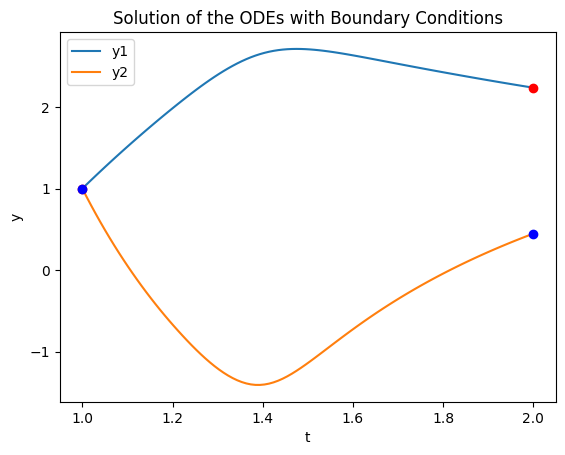

This solution is wrong, and I have no clue what so ever why I failed to solve it :((((((((((((((((((((((((((. also, slightly modifying the guess really affects the results


In [167]:
# Solve the problem. NOTE: if this runs for too long, that means your guess is bad! It also seems like the tolerance can heavily affect the calculation time. This method seems pretty hard to use since you really have to be smart when guessing and know how to pick a good tolerance

# Find the corrected initial conditions
better_guess = NR_shooting(guess_y3_y4_at_1)
y_at_1 = np.hstack((y1_y2_at_1, better_guess))

# Solve the ODEs
ode_solution = solve_ivp(f, t_span, y_at_1, t_eval=t_eval)

# Plot the solution and the boundary conditions: y1(1) = 1, y_1(2) = sqrt(5), y_2(1) = 1, y_2(2) = 1/sqrt(5)
plt.plot(ode_solution.t, ode_solution.y[0], label='y1')
plt.plot(ode_solution.t, ode_solution.y[1], label='y2')

# Add the boundary condition points
plt.scatter([1, 2], [1, np.sqrt(5)], color='red', zorder=5)  # y1 boundary conditions
plt.scatter([1, 2], [1, 1 / np.sqrt(5)], color='blue', zorder=5)  # y2 boundary conditions

plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Solution of the ODEs with Boundary Conditions')
plt.show()
print(
    "This solution is wrong, and I have no clue what so ever why I failed to solve it :((((((((((((((((((((((((((. also, slightly modifying the guess really affects the results")

Note: I implemented the methods in python in an ad-hoc manner for the specific problem I was facing because it was easier to implement. Using this codebase is not meant for general purpose problems, but the logic can still be gleaned from it for more general use cases. But my solution is wrong so never mind :(

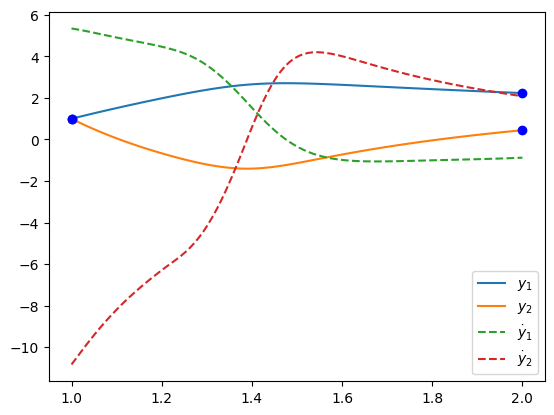

In [168]:
# Solution using the code I was given
def f(t, y):
    y1, y2, y3, y4 = y
    return np.array([y3, y4, -(1 / t) * y3 + (y2 ** 3) * (y1 ** 2 + 1), -(3 / t) * y4 - (y2 ** 5) * (y1 ** 2 + 3)])


y0s = np.array([1, 1])  # known initial values
yfs = np.array([np.sqrt(5), 1 / np.sqrt(5)])  # known final values
tspan = (1, 2)

y2_guess = 1.2
y3_guess = -0.6
y0g = np.array([y2_guess, y3_guess])  # guessed initial values


def F(y0g):
    y0 = np.hstack((y0s, y0g))  # all initial values
    sol = solve_ivp(f, tspan, y0)
    return sol.y[:2, -1] - yfs  # dist from known final values


def J(y0g):
    h = 0.001
    F_vv = F(y0g)  # F(y03, y04)
    F_vhv = F(y0g + h * np.array([1, 0]))  # F(y03+h, y04)
    F_vvh = F(y0g + h * np.array([0, 1]))  # F(y03, y04+h)
    return (1 / h) * np.array([
        [F_vhv[0] - F_vv[0], F_vvh[0] - F_vv[0]],
        [F_vhv[1] - F_vv[1], F_vvh[1] - F_vv[1]]
    ])


def NR_shooting(y0g):
    tol = 1e-5
    delta_s = np.inf
    while np.linalg.norm(delta_s) > tol:
        delta_s = -1 * np.linalg.solve(J(y0g), F(y0g))
        y0g = y0g + delta_s  # update initial guess
    return y0g


y0g = NR_shooting(y0g)
y0 = np.hstack((y0s, y0g))  # initial values with the updated guess
t_eval = np.linspace(tspan[0], tspan[1], 100)
sol = solve_ivp(f, tspan, y0, t_eval=t_eval)

# This also yields a wrong solution. IDK why :(
plt.plot(sol.t, sol.y[0], label=r'$y_1$')
plt.plot(sol.t, sol.y[1], label=r'$y_2$')
plt.plot(sol.t, sol.y[2], '--', label=r'$\dot{y}_1$')
plt.plot(sol.t, sol.y[3], '--', label=r'$\dot{y}_2$')
plt.plot(tspan, [y0s[0], yfs[0]], 'bo')
plt.plot(tspan, [y0s[1], yfs[1]], 'bo')
plt.legend()
plt.show()

### Question 2

#### The Relaxation method

$$\ddot{\theta} = -\omega^2 \sin(\theta) - \gamma \dot{\theta}$$

$$\theta(0) = \theta_0, \quad \theta(t_f) = 0$$

$$\dot \theta = s$$

$$\dot s = -\omega^2 \sin(\theta) - \gamma s$$

$ \frac{\theta_{i+1} - \theta_i}{h} = \frac{s_i + s_{i+1}}{2} $

$ \theta_{i+1} - \theta_i - \frac{h}{2}(s_i + s_{i+1}) = 0 $

$ \frac{s_{i+1} - s_i}{h} = -\omega^2 \sin(\frac{\theta_i + \theta_{i+1}}{2}) - \gamma \frac{s_i + s_{i+1}}{2} $

$ s_{i+1}(h\gamma + 2) + s_i(h\gamma - 2) + 2h\omega^2 \sin(\frac{\theta_i + \theta_{i+1}}{2}) = 0 $

#### Part A

$ \text{For N = 3, we get the 6 following equations: } $

$ F_0 = \theta_1 - \theta_0 - \frac{h}{2}(s_0 + s_1) = 0 $

$ F_1 = s_{1}(h\gamma + 2) + s_0(h\gamma - 2) + 2h\omega^2 \sin(\frac{\theta_0 + \theta_{1}}{2}) = 0 $

$ F_2 = \theta_2 - \theta_1 - \frac{h}{2}(s_1 + s_2) = 0 $

$ F_3 = s_{2}(h\gamma + 2) + s_1(h\gamma - 2) + 2h\omega^2 \sin(\frac{\theta_1 + \theta_{2}}{2}) = 0 $

$ F_4 = \theta_3 - \theta_2 - \frac{h}{2}(s_2 + s_3) = 0 $

$ F_5 = s_{3}(h\gamma + 2) + s_2(h\gamma - 2) + 2h\omega^2 \sin(\frac{\theta_2 + \theta_{3}}{2}) = 0 $

$$ ... $$

$ F_{2N - 2} = \theta_{N} - \theta_{N-1} - \frac{h}{2}(s_{N-1} + s_{N}) = 0 $
$ F_{2_N - 1} = s_{N}(h\gamma + 2) + s_{N-1}(h\gamma - 2) + 2h\omega^2 \sin(\frac{\theta_{N-1} + \theta_{N}}{2}) = 0 $

$ \text{The 6 unknowns are } s_0, s_1, \theta_1, \theta_2, s_2, s_3 $


$ \text{The Jacobian matrix (general form): } $

$ J = \begin{pmatrix}
\frac{\partial F_0}{\partial s_0} & \frac{\partial F_0}{\partial \theta_1} & \frac{\partial F_0}{\partial s_1} & \frac{\partial F_0}{\partial \theta_2} & \frac{\partial F_0}{\partial s_2} & \frac{\partial F_0}{\partial s_3} \\
\frac{\partial F_1}{\partial s_0} & \frac{\partial F_1}{\partial \theta_1} & \frac{\partial F_1}{\partial s_1} & \frac{\partial F_1}{\partial \theta_2} & \frac{\partial F_1}{\partial s_2} & \frac{\partial F_1}{\partial s_3} \\
\frac{\partial F_2}{\partial s_0} & \frac{\partial F_2}{\partial \theta_1} & \frac{\partial F_2}{\partial s_1} & \frac{\partial F_2}{\partial \theta_2} & \frac{\partial F_2}{\partial s_2} & \frac{\partial F_2}{\partial s_3} \\
\frac{\partial F_3}{\partial s_0} & \frac{\partial F_3}{\partial \theta_1} & \frac{\partial F_3}{\partial s_1} & \frac{\partial F_3}{\partial \theta_2} & \frac{\partial F_3}{\partial s_2} & \frac{\partial F_3}{\partial s_3} \\
\frac{\partial F_4}{\partial s_0} & \frac{\partial F_4}{\partial \theta_1} & \frac{\partial F_4}{\partial s_1} & \frac{\partial F_4}{\partial \theta_2} & \frac{\partial F_4}{\partial s_2} & \frac{\partial F_4}{\partial s_3} \\
\frac{\partial F_5}{\partial s_0} & \frac{\partial F_5}{\partial \theta_1} & \frac{\partial F_5}{\partial s_1} & \frac{\partial F_5}{\partial \theta_2} & \frac{\partial F_5}{\partial s_2} & \frac{\partial F_5}{\partial s_3} \\
\end{pmatrix} $

$ \text{The Jacobian matrix: } $

$ c_{i,j} = h\omega^2 \cos(\frac{\theta_i + \theta_{j}}{2}) $

$ J = \begin{pmatrix}
-h/2 & 1 & -h/2 & 0 & 0 & 0 \\
h\gamma - 2 & c_{0, 1} & h\gamma + 2 & 0 & 0 & 0 \\
0 & -1 & -h/2 & 1 & -h/2 & 0 \\
0 & c_{1,2} & h\gamma - 2 & c_{1,2} & h\gamma + 2 & 0 \\
0 & 0 & 0 & -1 & -h/2 & -h/2 \\
0 & 0 & 0 & c_{2,3} & h\gamma - 2 & h\gamma + 2 \\
\end{pmatrix} $

#### Part B

$ \omega = 1, \gamma = 0.5, t_f = 15, \theta_0 = \frac{\pi}{4} $

$ \theta(t) = \theta_0 \cos(\frac{\pi}{2t_f}t) $

$ s(t) = -\frac{\pi}{2t_f}\theta_0 \sin(\frac{\pi}{2t_f}t) $

In [169]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

In [170]:
# this doesnt work I have no idea why I get not a number. I can't waste more time on this
w = 1
gamma = 0.5
theta_0 = np.pi / 4
theta_f = 0

N = 1000  # number of segments
N_eq = 2 * N  # number of equations

tspan = (0, 15)
t_val = np.linspace(tspan[0], tspan[1], N + 1)  # edges of N segments
h = (tspan[1] - tspan[0]) / N


def F(theta, s):
    f = np.zeros(N_eq)
    for i in range(N):
        f[2 * i] = theta[i + 1] - theta[i] - 0.5 * h * (s[i] + s[i + 1])
        f[2 * i + 1] = s[i + 1] * (h * gamma + 2) - s[i] * (h * gamma - 2) + 2 * h * (w ** 2) * np.sin(
            0.5 * (theta[i] + theta[i + 1]))
    return f


def J(y, s):
    M = np.zeros((N_eq, N_eq))
    M[0, 0:3] = np.array([-0.5 * h, 1, -0.5 * h])
    M[1, 0:3] = np.array([h * gamma - 2, h * (w ** 2) * np.cos(0.5 * (y[0] + y[1])), h * gamma])
    for i in range(1, N - 1):
        j = 2 * i
        c = h * (w ** 2) * np.cos(0.5 * (y[i] + y[i + 1]))  # c_i,j
        M[j, j - 1:j + 3] = np.array([-1, -0.5 * h, 1, -0.5 * h])
        M[j + 1, j - 1:j + 3] = np.array([c, h * gamma - 2, c, h * gamma + 2])
    M[-2, -3:] = np.array([-1, -0.5 * h, -0.5 * h])
    M[-1, -3:] = np.array([0.5 * h * (w ** 2) * np.cos(0.5 * (y[-2] + y[-1])), h * gamma - 2, h * gamma + 2])
    return csr_matrix(M)

# This is a terrible name because THIS DOES NOT MAKE ME FEEL RELAXED AT ALL WHAT SO FUCKING EVER FUCK WHY DOES THIS NOT WORKKKKKKKKKKKKKKKKKKK
def NR_relax(theta, s):
    tol = 1e-5
    delta_x = np.inf
    # convert from y,s to x:
    x = np.zeros(N_eq)
    x[0::2] = s[:-1]
    x[-1] = s[-1]
    x[1:-1:2] = theta[1:-1]
    while np.linalg.norm(delta_x) > tol:
        delta_x = -1 * spsolve(J(theta, s), F(theta, s))
        x = x + delta_x
        # update y,s according to x:
        theta = np.hstack(([theta_0], x[1:N_eq - 1:2], [theta_f]))
        s = np.hstack((x[0::2], x[-1]))
    return theta, s


# initial guesses for all variables:
theta = theta_0 * np.cos(np.pi / (2* t_span[1]) * t_val)
s = (-np.pi / (2 * t_span[1])) * theta_0 * np.sin(np.pi / (2 * t_span[1]) * t_val)
# make sure known values are correct:
theta[0] = theta_0
theta[-1] = theta_f

theta, s = NR_relax(theta, s)  # find the correct variables
theta

# # Plot the solution
# plt.plot(t_val,theta,label=r'$\theta$')
# plt.plot(t_val,s,label='$\dot{\\theta}$')
# plt.plot(tspan, [theta_0, theta_f], 'bo')
# plt.legend()
# plt.show()

array([0.78539816,        nan,        nan, ...,        nan,        nan,
       0.        ])

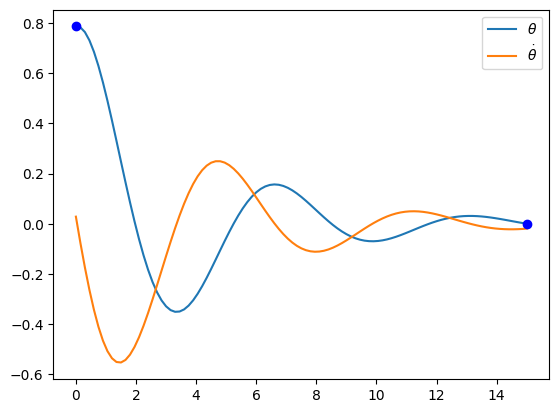

In [171]:
w = 1
gamma = 0.5
theta_0 = np.pi / 4
theta_f = 0

N = 100  # number of segments
N_eq = 2 * N  # number of equations

tspan = (0, 15)
t_val = np.linspace(tspan[0], tspan[1], N + 1)  # edges of N segments
h = (tspan[1] - tspan[0]) / N


def F(theta, s):
    f = np.zeros(N_eq)
    for i in range(N):
        f[2 * i] = theta[i + 1] - theta[i] - 0.5 * h * (s[i] + s[i + 1])
        # For some reason everything I tried gave me a bad result and I already wasted too many hours on this exercise and nothing works. I will this
        f[2 * i + 1] = s[i+1] - s[i] + h*((w**2)*np.sin(0.5*(theta[i]+theta[i+1]) + (gamma)*(0.5*(s[i+1] + s[i]))))
    return f


def J(theta, s):
    M = np.zeros((N_eq, N_eq))
    M[0, 0:3] = np.array([-0.5 * h, 1, -0.5 * h])
    M[1,0:3] = np.array([-1 + h*gamma/2 , 0.5*h*(w**2)*np.cos(0.5*(theta[0]+theta[1])), 1+ h*gamma/2])
    for i in range(1, N - 1):
        j = 2 * i
        c = 0.5*h*(w**2)*np.cos(0.5*(theta[i]+theta[i+1]))
        M[j,j-1:j+3] = np.array([-1, -0.5*h, 1, -0.5*h])
        M[j+1,j-1:j+3] = np.array([c, -1+ h*gamma/2 , c, 1 + h*gamma/2])
    M[-2,-3:] = np.array([-1, -0.5*h, -0.5*h])
    M[-1,-3:] = np.array([0.5*h*(w**2)*np.cos(0.5*(theta[-2]+theta[-1])), -1 + h*gamma/2, 1 + h*gamma/2])
    return csr_matrix(M)

# This is a terrible name because THIS DOES NOT MAKE ME FEEL RELAXED AT ALL WHY DOES THIS NOT WORKKKKKKKKKKKKKKKKKKK
def NR_relax(theta, s):
    tol = 1e-5
    delta_x = np.inf
    # convert from y,s to x:
    x = np.zeros(N_eq)
    x[0::2] = s[:-1]
    x[-1] = s[-1]
    x[1:-1:2] = theta[1:-1]
    while np.linalg.norm(delta_x) > tol:
        delta_x = -1 * spsolve(J(theta, s), F(theta, s))
        x = x + delta_x
        # update y,s according to x:
        theta = np.hstack(([theta_0], x[1:N_eq - 1:2], [theta_f]))
        s = np.hstack((x[0::2], x[-1]))
    return theta, s


# initial guesses for all variables:
theta = (np.pi/4) * np.cos(np.pi*t_val/(2*tspan[1]))
s = -(np.pi**2/(8*tspan[1])) * np.sin(np.pi*t_val/(2*tspan[1]))
# make sure known values are correct:
theta[0] = theta_0
theta[-1] = theta_f

theta, s = NR_relax(theta, s)  # find the correct variables
theta

# Plot the solution
plt.plot(t_val,theta,label=r'$\theta$')
plt.plot(t_val,s,label='$\dot{\\theta}$')
plt.plot(tspan, [theta_0, theta_f], 'bo')
plt.legend()
plt.show()

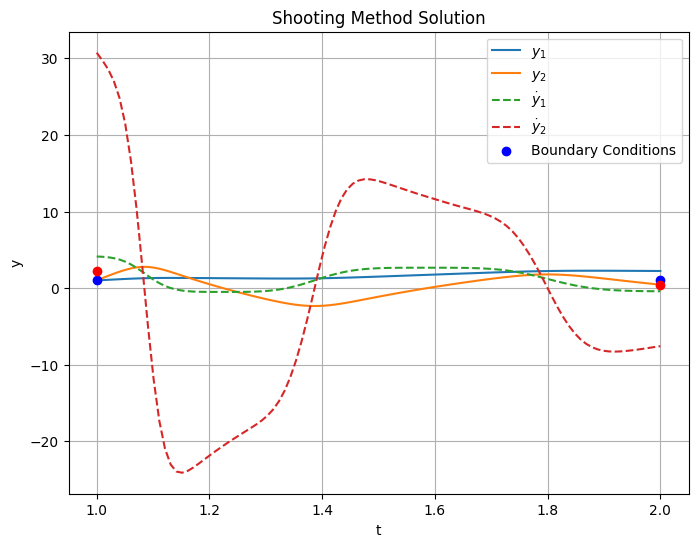

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Define the system of equations for the shooting method
def f(t, y):
    return np.array([
        y[2],
        y[3],
        -y[1]**3 * (y[0]**2 + 1) / t,
        -3 * y[3] / t - y[1]**5 * (y[0]**2 + 3),
    ])

# Known initial and final values
y0s = np.array([1, 1])  # Boundary values at t = 1
yfs = np.array([np.sqrt(5), 1/np.sqrt(5)])  # Boundary values at t = 2
tspan = (1, 2)

# Initial guesses for the missing initial conditions
y2_guess = 1
y3_guess = 1
y0g = np.array([y2_guess, y3_guess], dtype=float)

# Define the mismatch function
def F(y0g):
    y0 = np.hstack((y0s, y0g))
    sol = solve_ivp(f, tspan, y0, t_eval=[tspan[1]])
    return sol.y[:2, -1] - yfs

# Compute the Jacobian numerically
def J(y0g):
    h = 1e-5
    F_vv = F(y0g)
    F_vhv = F(y0g + h * np.array([1, 0]))
    F_vvh = F(y0g + h * np.array([0, 1]))
    return (1 / h) * np.array([
        [F_vhv[0] - F_vv[0], F_vvh[0] - F_vv[0]],
        [F_vhv[1] - F_vv[1], F_vvh[1] - F_vv[1]]
    ])

# Newton-Raphson method for the shooting method
def NR_shooting(y0g):
    tol = 1e-5
    delta_s = np.inf
    while np.linalg.norm(delta_s) > tol:
        delta_s = -1 * np.linalg.solve(J(y0g), F(y0g))
        y0g += delta_s
    return y0g

# Solve using the shooting method
y0g = NR_shooting(y0g)
y0 = np.hstack((y0s, y0g))
t_eval = np.linspace(tspan[0], tspan[1], 100)
sol = solve_ivp(f, tspan, y0, t_eval=t_eval)

# Plot the solutions
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label=r'$y_1$')
plt.plot(sol.t, sol.y[1], label=r'$y_2$')
plt.plot(sol.t, sol.y[2], '--', label=r'$\dot{y}_1$')
plt.plot(sol.t, sol.y[3], '--', label=r'$\dot{y}_2$')
plt.scatter(tspan, y0s, color='blue', label='Boundary Conditions', zorder=5)
plt.scatter(tspan, yfs, color='red', zorder=5)
plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.title('Shooting Method Solution')
plt.grid()
plt.show()